<a href="https://colab.research.google.com/github/Momilijaz96/Video-Based-Fall-Detection-with-Attention/blob/main/LPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import logging
import math
import torch
import torch.nn as nn
from torchvision import transforms
import cv2
from google.colab.patches import cv2_imshow
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
BN_MOMENTUM=0.1

# Configurations

In [ ]:
!pip install yacs

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from yacs.config import CfgNode as CN

_C = CN()

_C.OUTPUT_DIR = ''
_C.LOG_DIR = ''
_C.DATA_DIR = ''
_C.GPUS = (0,)
_C.WORKERS = 4
_C.PRINT_FREQ = 20
_C.AUTO_RESUME = False
_C.PIN_MEMORY = True
_C.RANK = 0

# Cudnn related params
_C.CUDNN = CN()
_C.CUDNN.BENCHMARK = True
_C.CUDNN.DETERMINISTIC = False
_C.CUDNN.ENABLED = True

# common params for NETWORK
_C.MODEL = CN()
_C.MODEL.NAME = 'pose_hrnet'
_C.MODEL.INIT_WEIGHTS = True
_C.MODEL.PRETRAINED = ''
_C.MODEL.NUM_JOINTS = 17
_C.MODEL.TAG_PER_JOINT = True
_C.MODEL.TARGET_TYPE = 'gaussian'
_C.MODEL.IMAGE_SIZE = [256, 256]  # width * height, ex: 192 * 256
_C.MODEL.HEATMAP_SIZE = [64, 64]  # width * height, ex: 24 * 32
_C.MODEL.SIGMA = 2
_C.MODEL.EXTRA = CN(new_allowed=True)

_C.LOSS = CN()
_C.LOSS.USE_OHKM = False
_C.LOSS.TOPK = 8
_C.LOSS.USE_TARGET_WEIGHT = True
_C.LOSS.USE_DIFFERENT_JOINTS_WEIGHT = False

# DATASET related params
_C.DATASET = CN()
_C.DATASET.ROOT = ''
_C.DATASET.DATASET = 'mpii'
_C.DATASET.TRAIN_SET = 'train'
_C.DATASET.TEST_SET = 'valid'
_C.DATASET.DATA_FORMAT = 'jpg'
_C.DATASET.HYBRID_JOINTS_TYPE = ''
_C.DATASET.SELECT_DATA = False

# training data augmentation
_C.DATASET.FLIP = True
_C.DATASET.SCALE_FACTOR = 0.25
_C.DATASET.ROT_FACTOR = 30
_C.DATASET.PROB_HALF_BODY = 0.0
_C.DATASET.NUM_JOINTS_HALF_BODY = 8
_C.DATASET.COLOR_RGB = False

# train
_C.TRAIN = CN()

_C.TRAIN.LR_FACTOR = 0.1
_C.TRAIN.LR_STEP = [90, 110]
_C.TRAIN.LR = 0.001

_C.TRAIN.OPTIMIZER = 'adam'
_C.TRAIN.MOMENTUM = 0.9
_C.TRAIN.WD = 0.0001
_C.TRAIN.NESTEROV = False
_C.TRAIN.GAMMA1 = 0.99
_C.TRAIN.GAMMA2 = 0.0

_C.TRAIN.BEGIN_EPOCH = 0
_C.TRAIN.END_EPOCH = 140

_C.TRAIN.RESUME = False
_C.TRAIN.CHECKPOINT = ''

_C.TRAIN.BATCH_SIZE_PER_GPU = 32
_C.TRAIN.SHUFFLE = True

# testing
_C.TEST = CN()

# size of images for each device
_C.TEST.BATCH_SIZE_PER_GPU = 32
# Test Model Epoch
_C.TEST.FLIP_TEST = False
_C.TEST.POST_PROCESS = False
_C.TEST.SHIFT_HEATMAP = False

_C.TEST.USE_GT_BBOX = False

# nms
_C.TEST.IMAGE_THRE = 0.1
_C.TEST.NMS_THRE = 0.6
_C.TEST.SOFT_NMS = False
_C.TEST.OKS_THRE = 0.5
_C.TEST.IN_VIS_THRE = 0.0
_C.TEST.COCO_BBOX_FILE = ''
_C.TEST.BBOX_THRE = 1.0
_C.TEST.MODEL_FILE = ''

# soft_argmax
_C.TEST.SOFT_ARGMAX = False
_C.TEST.BIAS = 0.0

# debug
_C.DEBUG = CN()
_C.DEBUG.DEBUG = False
_C.DEBUG.SAVE_BATCH_IMAGES_GT = False
_C.DEBUG.SAVE_BATCH_IMAGES_PRED = False
_C.DEBUG.SAVE_HEATMAPS_GT = False
_C.DEBUG.SAVE_HEATMAPS_PRED = False


def update_config(cfg, args):
    cfg.defrost()
    cfg.merge_from_file(args)
    # cfg.merge_from_list(args.opts)

    #if args.modelDir:
     #   cfg.OUTPUT_DIR = args.modelDir

    #if args.logDir:
     #   cfg.LOG_DIR = args.logDir

    # if args.dataDir:
    #     cfg.DATA_DIR = args.dataDir

    cfg.DATASET.ROOT = os.path.join(
        cfg.DATA_DIR, cfg.DATASET.ROOT
    )

    cfg.MODEL.PRETRAINED = os.path.join(
        cfg.DATA_DIR, cfg.MODEL.PRETRAINED
    )

    if cfg.TEST.MODEL_FILE:
        cfg.TEST.MODEL_FILE = os.path.join(
            cfg.DATA_DIR, cfg.TEST.MODEL_FILE
        )

    cfg.freeze()

In [ ]:
cfg=_C

# LightWeight Modules


### Initialization functions

In [ ]:
def constant_init(module, val, bias=0):
    nn.init.constant_(module.weight, val)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)


def xavier_init(module, gain=1, bias=0, distribution='normal'):
    assert distribution in ['uniform', 'normal']
    if distribution == 'uniform':
        nn.init.xavier_uniform_(module.weight, gain=gain)
    else:
        nn.init.xavier_normal_(module.weight, gain=gain)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)


def normal_init(module, mean=0, std=1, bias=0):
    nn.init.normal_(module.weight, mean, std)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)


def uniform_init(module, a=0, b=1, bias=0):
    nn.init.uniform_(module.weight, a, b)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)


def kaiming_init(module,
                 a=0,
                 mode='fan_out',
                 nonlinearity='relu',
                 bias=0,
                 distribution='normal'):
    assert distribution in ['uniform', 'normal']
    if distribution == 'uniform':
        nn.init.kaiming_uniform_(
            module.weight, a=a, mode=mode, nonlinearity=nonlinearity)
    else:
        nn.init.kaiming_normal_(
            module.weight, a=a, mode=mode, nonlinearity=nonlinearity)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)

def last_zero_init(m):
    if isinstance(m, nn.Sequential):
        constant_init(m[-1], val=0)
        m[-1].inited = True
    else:
        constant_init(m, val=0)
        m.inited = True

### LightWeight BottleNeck

In [ ]:
class LW_Bottleneck(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, attention='GC'):
        super(LW_Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if attention == 'SE':
            self.att = SELayer(planes * self.expansion)
        elif attention == 'GC':
            out_planes = planes * self.expansion // 16 if planes * self.expansion // 16 >= 16 else 16
            self.att = GCBlock(planes * self.expansion, out_planes, 'att', ['channel_add'])
        else:
            self.att = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.att is not None:
            out = self.att(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

### Global Context Block

In [ ]:
class GCBlock(nn.Module):

    def __init__(self, inplanes, planes, pool, fusions):
        super(GCBlock, self).__init__()
        assert pool in ['avg', 'att']
        assert all([f in ['channel_add', 'channel_mul'] for f in fusions])
        assert len(fusions) > 0, 'at least one fusion should be used'
        self.inplanes = inplanes
        self.planes = planes
        self.pool = pool
        self.fusions = fusions
        if 'att' in pool:
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
        if 'channel_add' in fusions:
            self.channel_add_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1)
            )
        else:
            self.channel_add_conv = None
        if 'channel_mul' in fusions:
            self.channel_mul_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1)
            )
        else:
            self.channel_mul_conv = None
        self.reset_parameters()

    def reset_parameters(self):
        if self.pool == 'att':
            kaiming_init(self.conv_mask, mode='fan_in')
            self.conv_mask.inited = True

        if self.channel_add_conv is not None:
            last_zero_init(self.channel_add_conv)
        if self.channel_mul_conv is not None:
            last_zero_init(self.channel_mul_conv)

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pool == 'att':
            input_x = x
            # [N, C, H * W]
            input_x = input_x.view(batch, channel, height * width)
            # [N, 1, C, H * W]
            input_x = input_x.unsqueeze(1)
            # [N, 1, H, W]
            context_mask = self.conv_mask(x)
            # [N, 1, H * W]
            context_mask = context_mask.view(batch, 1, height * width)
            # [N, 1, H * W]
            context_mask = self.softmax(context_mask)
            # [N, 1, H * W, 1]
            context_mask = context_mask.unsqueeze(3)
            # [N, 1, C, 1]
            context = torch.matmul(input_x, context_mask)
            # [N, C, 1, 1]
            context = context.view(batch, channel, 1, 1)
        else:
            # [N, C, 1, 1]
            context = self.avg_pool(x)

        return context

    def forward(self, x):
        # [N, C, 1, 1]
        context = self.spatial_pool(x)

        if self.channel_mul_conv is not None:
            # [N, C, 1, 1]
            channel_mul_term = torch.sigmoid(self.channel_mul_conv(context))
            out = x * channel_mul_term
        else:
            out = x
        if self.channel_add_conv is not None:
            # [N, C, 1, 1]
            channel_add_term = self.channel_add_conv(context)
            out = out + channel_add_term
        return out

# Lightweight Pose Network

In [ ]:
class LPN(nn.Module):

  def __init__(self,block,layers,cfg,**kwargs):
    '''
    Parameters:
      block = LWNet block class instance
      layers= list of numbers like [3,4,6,3] based on resnet arch chosen from terminal
      cfg= yacs configuration obecjts
      **kwargs = other kwargs passed in the class instance
    '''
    super(LPN,self).__init__()

    self.inplanes=64
    extra = cfg.MODEL.EXTRA #Extra KWArgs passed to model from the terminal
    self.deconv_with_bias = extra.DECONV_WITH_BIAS #Bool to tell if we need bias in deconv layers
    self.attention = extra.get('ATTENTION') #Type of attention Attention block GC or SE


    self.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1=nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
    self.relu=nn.ReLU(inplace=True)
    self.maxpool=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    #Make upsampling layers
    self.layer1=self._make_layer(block,64,layers[0]) #This layer has layers[0] LW blocks
    self.layer2=self._make_layer(block,128,layers[1],stride=2) #This layers has layers[1] LW blocks
    self.layer3=self._make_layer(block,256,layers[2],stride=2) 
    self.layer4=self._make_layer(block,512,layers[3],stride=1)

    #Make upsampling layers
    self.deconv_layers= self._make_deconv_layer(
            extra.NUM_DECONV_LAYERS,
            extra.NUM_DECONV_FILTERS,
            extra.NUM_DECONV_KERNELS,
        )
    
    #Set final layer up
    self.final_layer= nn.Conv2d(
            in_channels=extra.NUM_DECONV_FILTERS[-1], #input channels are equivalent to output of prev layer
            out_channels=cfg.MODEL.NUM_JOINTS, #Output channels is equal to num of joints, each channel is a heatmap for each joint
            kernel_size=extra.FINAL_CONV_KERNEL, #from termimal args
            stride=1,
            padding=1 if extra.FINAL_CONV_KERNEL == 3 else 0
        )
    

  #Function for making downsampling layers through convolution
  def _make_layer(self,block,planes,blocks,stride=1):
    '''
    Parameters:
      block= LWNet block instance
      planes= Numbe rof output channels for this layer
      blocks= Number of LWNet blocks in this layer
      stride= Stride size for this block

    '''
    downsample=None
    if stride!=1 or self.inplanes!=planes*block.expansion: #if stride>1 or outchannels != inchannels
      downsample=nn.Sequential(
          nn.Conv2d(self.inplanes,planes*block.expansion,
                    kernel_size=1,stride=stride,bias=False),
          nn.BatchNorm2d(planes*block.expansion, momentum=BN_MOMENTUM)
      )
    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, self.attention))
    self.inplanes = planes * block.expansion
    for i in range(1, blocks):
        layers.append(block(self.inplanes, planes, attention=self.attention))

    return nn.Sequential(*layers)

  #Function for getting deconv cong
  #     Specifically, padding size for a layer given it's kernel size
  def _get_deconv_cfg(self, deconv_kernel, index):
      if deconv_kernel == 4:
          padding = 1
          output_padding = 0
      elif deconv_kernel == 3:
          padding = 1
          output_padding = 1
      elif deconv_kernel == 2:
          padding = 0
          output_padding = 0

      return deconv_kernel, padding, output_padding

  #Function for making deconv layers
  def _make_deconv_layer(self,num_layers,num_filters,num_kernels):
    '''
    Parameters:
    num_layers = Number of deconvolution layers, Scalar
    num_filters = Number of output channels for each layer, List of size num_layers
    deconv_kernels = Size of kernel for each layer, List of size num_layers
    '''
    layers=[]
    for i in range(num_layers): #Passed from terminal args, ususally 2
      kernel, padding, output_padding = \
              self._get_deconv_cfg(num_kernels[i], i)
      planes=num_filters[i] #get the output channels count for this layer
      layers.extend([ #Add this list to end of layers list
              nn.ConvTranspose2d(in_channels=self.inplanes,out_channels=planes,kernel_size=kernel,
                stride=2,padding=padding,output_padding=output_padding,
                groups=math.gcd(self.inplanes,planes),bias=self.deconv_with_bias),
              nn.BatchNorm2d(planes,momentum=BN_MOMENTUM),
              nn.ReLU(inplace=True),
              nn.Conv2d(planes,planes,kernel_size=1,bias=False),
              nn.BatchNorm2d(planes,momentum=BN_MOMENTUM),
              nn.ReLU(inplace=True),
      ])
      self.inplanes=planes #Reset the input planes equal to output planes of previous layer

    return nn.Sequential(*layers)

  #Forward pass through LPN
  def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)

      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)

      features = self.deconv_layers(x)
      x = self.final_layer(features)

      return x

  #Weight initializer
  def init_weights(self,pretrained=''):
    #If we have a set of pretrained weights, then init the weights of deconv and final layer
    #and use pretrained weights for the conv layers
    if os.path.isfile(pretrained):

      #Initialize weights of the deconv layers
      print("Initialize deconv weights from normal distribution")
      for name,m in self.deconv_layers.named_modules():
        
        if isinstance(m,nn.ConvTranspose2d):
          nn.init.normal_(m.weight, std=0.001)
          if self.deconv_with_bias:
              nn.init.constant_(m.bias, 0)
        
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
      
      #Initialize weights of the final layer
      print("Initilize weights of the final layer")
      for m in self.final_layer.modules():

        if isinstance(m, nn.Conv2d):
          nn.init.normal_(m.weight, std=0.001)
          nn.init.constant_(m.bias, 0)

      #Load the weights for the conv/downsample layers
      pretrained_state_dict = torch.load(pretrained)
      print('=> loading pretrained model ',pretrained)
      self.load_state_dict(pretrained_state_dict, strict=False)


    else: #If we dont have a set of pretrained weights, then simply initialize weights for the whole network
      print('=> init weights from normal distribution')
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.normal_(m.weight, std=0.001)
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.ConvTranspose2d):
              nn.init.normal_(m.weight, std=0.001)
              if self.deconv_with_bias:
                  nn.init.constant_(m.bias, 0)
  




# Configure and Create **LPN**

### Configuration

In [ ]:
#Dictionary for selecting downsample part of LWN
resnet_spec = {
    50: (LW_Bottleneck, [3, 4, 6, 3]),
    101: (LW_Bottleneck, [3, 4, 23, 3]),
    152: (LW_Bottleneck, [3, 8, 36, 3])
}

In [ ]:
#Function to get the pose network
def get_pose_net(cfg, is_train, **kwargs):
    num_layers = cfg.MODEL.EXTRA.NUM_LAYERS

    block_class, layers = resnet_spec[num_layers]

    model = LPN(block_class, layers, cfg, **kwargs)

    if is_train and cfg.MODEL.INIT_WEIGHTS:
        model.init_weights(cfg.MODEL.PRETRAINED)

    return model

In [ ]:
#Command line arguments for defining pose net
import yaml
conf_file='/content/drive/MyDrive/Colab Notebooks/Fall Detection/conf.yaml'
update_config(cfg,conf_file)

In [ ]:
model=get_pose_net(cfg,is_train=False)
model

LPN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): LW_Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (att): GCBlock(
        (conv_mask): Conv2d(64, 1, kernel_size=(1, 1), stride

## Inference

In [ ]:
img_file='/content/drive/MyDrive/Colab Notebooks/Fall Detection/img.jpeg'
img = cv2.imread(img_file)
#img = cv2.resize(img, (256, 192)) 
img=img.astype('float32')

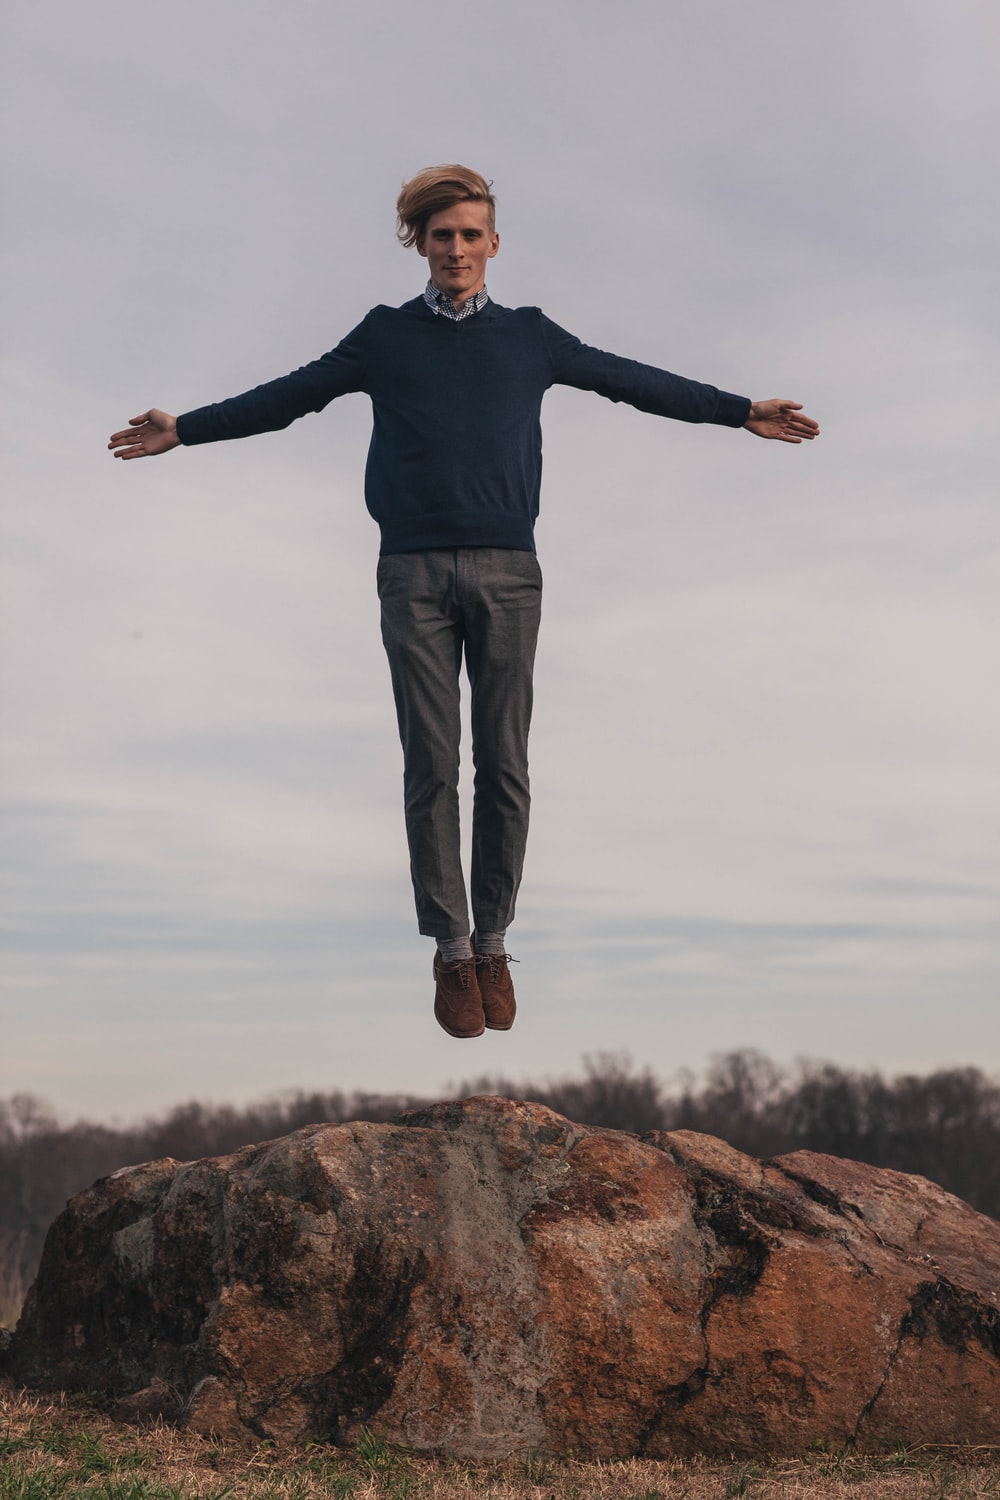

In [ ]:
cv2_imshow(img)

In [ ]:
img = np.moveaxis(img, -1, 0)
img.shape

(3, 1500, 1000)

In [ ]:
img=img[None,:,:,:]
img.shape

(1, 3, 1500, 1000)

In [ ]:
img_tensor=torch.from_numpy(img)
img_tensor.shape

torch.Size([1, 3, 1500, 1000])

In [ ]:
out=model(img_tensor)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter w

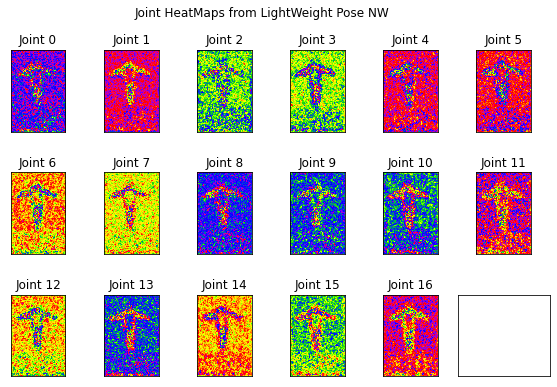

In [ ]:
fig, axs = plt.subplots(3,6, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.01)

axs = axs.ravel();
fig.suptitle("Joint HeatMaps from LightWeight Pose NW")
axs[17].set_xticks([],[]);
axs[17].set_yticks([],[]);
for i in range(17):

    axs[i].imshow(out[0,i,:,:].detach().numpy()*1000,cmap='prism');
    axs[i].set_title('Joint '+str(i));
    axs[i].set_xticks([],[]);
    axs[i].set_yticks([],[]);